# Classificatio with KNN

Dataset preparation

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [68]:
df = pd.read_csv('df_cleaned.csv', skipinitialspace=True, header=0)
X = df.drop(columns=['rating_category',"originalTitle","totalImages", "totalVideos", "countryOfOrigin", "canHaveEpisodes", "runtimeMinutes", "rating"])
y = df['rating_category']

#Portioning 

In [69]:
from sklearn.model_selection import train_test_split, StratifiedKFold


In [70]:
# dataset division with stratify

RANDOM_STATE = 0
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

K_FOLD = StratifiedKFold(n_splits = 5, shuffle = True, random_state = RANDOM_STATE)

print("NaN in X_train['genres']:", X_train['genres'].isna().sum())
print("NaN in X_test['genres']:", X_test['genres'].isna().sum())
print("Controllo tipi in X_train['genres']:")
print(X_train['genres'].apply(type).value_counts())

print("Controllo tipi in X_test['genres']:")
print(X_test['genres'].apply(type).value_counts())




NaN in X_train['genres']: 0
NaN in X_test['genres']: 0
Controllo tipi in X_train['genres']:
genres
<class 'str'>    8663
Name: count, dtype: int64
Controllo tipi in X_test['genres']:
genres
<class 'str'>    2166
Name: count, dtype: int64


# Encoding

In [71]:
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer

In [72]:
X_train['genres'] = X_train['genres'].fillna('').str.split(',')
X_test['genres'] = X_test['genres'].fillna('').str.split(',')
print("Controllo tipi dopo lo split:")
print(X_train['genres'].apply(type).value_counts())

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# genres: MultiLabelBinarizer
mlb = MultiLabelBinarizer()
genres_train = mlb.fit_transform(X_train['genres'])
genres_test = mlb.transform(X_test['genres'])

# One-hot encoding su titleType e continent
X_cat_train = pd.get_dummies(X_train[['titleType', 'continent']], drop_first=True)
X_cat_test = pd.get_dummies(X_test[['titleType', 'continent']], drop_first=True)

# Allineamento colonne test rispetto al train
X_cat_test = X_cat_test.reindex(columns=X_cat_train.columns, fill_value=0)

# Selezione colonne numeriche
X_num_train = X_train.select_dtypes(include=[np.number])
X_num_test = X_test.select_dtypes(include=[np.number])

# Costruzione dei dataset finali in formato DENSE
X_train_enc = np.hstack([
    X_num_train.values,
    genres_train,
    X_cat_train.values
])

X_test_enc = np.hstack([
    X_num_test.values,
    genres_test,
    X_cat_test.values
])

# Verifica consistenza
print("Colonne numeriche:", X_num_train.columns.tolist())
print("X_train_enc shape:", X_train_enc.shape)
print("X_test_enc shape:", X_test_enc.shape)
print(type(X_train_enc))

assert X_train_enc.shape[1] == X_test_enc.shape[1], "Numero di colonne tra train e test non corrisponde!"


Controllo tipi dopo lo split:
genres
<class 'list'>    8663
Name: count, dtype: int64
Colonne numeriche: ['awardWins', 'totalCredits', 'criticReviewsTotal', 'awardNominationsExcludeWins', 'numRegions', 'userReviewsTotal', 'decade', 'totalReviews', 'num_ratings']
X_train_enc shape: (8663, 51)
X_test_enc shape: (2166, 51)
<class 'numpy.ndarray'>


# GridSearch 

In [73]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Parametri da esplorare con GridSearchCV
param_grid = {
    "n_neighbors": np.arange(1, min(101, X_train_enc.shape[0] // 5)),  # Numero di vicini
    "weights": ["uniform", "distance"],  # Pesatura dei vicini
    "metric": ["euclidean", "cityblock"],  # Metodi di distanza
}

grid = GridSearchCV(
    KNeighborsClassifier(algorithm='auto'),# Usa ball_tree per velocizzare il calcolo delle distanze
    param_grid=param_grid,  # Parametri da ottimizzare
    cv= K_FOLD,  # K-fold stratificato ripetuto metti la variabile 
    scoring = 'balanced_accuracy',
    n_jobs=-1,  # Usa tutti i core del processore
    refit=True,  # Ritorna il modello migliore
)

# Esegui la ricerca
grid.fit(X_train_enc, y_train_enc) 

# Estrai il modello migliore
clf = grid.best_estimator_

# Mostra i migliori iperparametri e la miglior performance
print("Migliori parametri trovati:", grid.best_params_)
print("Miglior punteggio:", grid.best_score_)


Migliori parametri trovati: {'metric': 'euclidean', 'n_neighbors': np.int64(70), 'weights': 'uniform'}
Miglior punteggio: 0.36125998710505614


In [74]:
# Controllo la distribuzione della variabile target 
print(y_train.value_counts())

rating_category
Media    4440
Alta     3863
Bassa     360
Name: count, dtype: int64


In [75]:
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    confusion_matrix, roc_auc_score, roc_curve, auc
)
from sklearn.preprocessing import label_binarize

# Predizioni sui dati di test
y_test_pred = clf.predict(X_test_enc)

In [76]:
print("Accuracy:", accuracy_score(y_test_enc, y_test_pred))

Accuracy: 0.4995383194829178


In [77]:
print("F1 Macro:", f1_score(y_test_enc, y_test_pred, average="macro"))

F1 Macro: 0.33655011991626743


In [78]:
print("F1 Macro:", f1_score(y_test_enc, y_test_pred, average="micro"))

F1 Macro: 0.4995383194829178


In [79]:
print("\nClassification Report:\n", classification_report(y_test_enc, y_test_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.45      0.46       966
           1       0.00      0.00      0.00        90
           2       0.52      0.59      0.55      1110

    accuracy                           0.50      2166
   macro avg       0.33      0.34      0.34      2166
weighted avg       0.48      0.50      0.49      2166



c:\Users\rache\miniconda3\envs\prova\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rache\miniconda3\envs\prova\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rache\miniconda3\envs\prova\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# ***CONFUSION MATRIX***

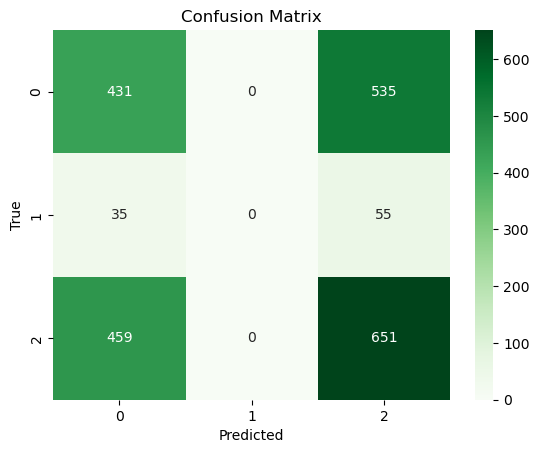

In [80]:
cf = confusion_matrix(y_test_enc, y_test_pred)
sns.heatmap(cf, annot=True, cmap="Greens", fmt='d')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# --- ROC Curve Multiclasse ---

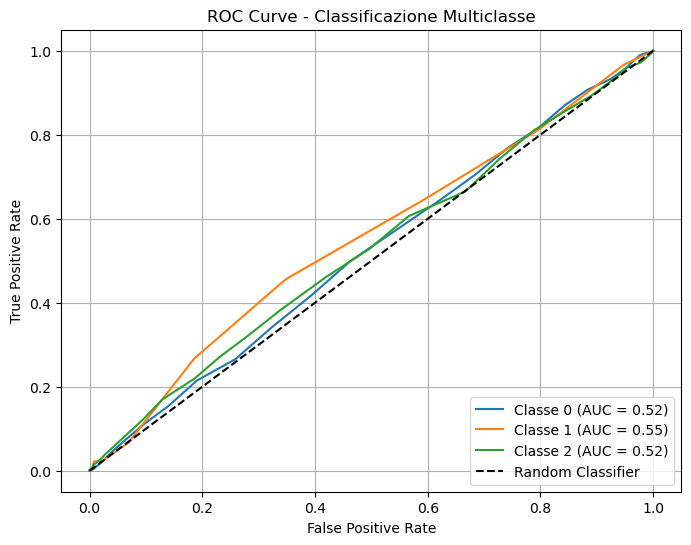

ROC AUC macro: 0.5312506820895654


In [81]:

# Otteniamo le probabilità
y_test_pred_proba = clf.predict_proba(X_test_enc)

# Binarizziamo le etichette (necessario per ROC multiclasse)
n_classes = y_test_pred_proba.shape[1]
y_test_binarized = label_binarize(y_test_enc, classes=np.arange(n_classes))

# Calcolo curve ROC per ogni classe
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_test_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curve
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Classe {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Classificazione Multiclasse")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# AUC complessiva
print("ROC AUC macro:", roc_auc_score(y_test_binarized, y_test_pred_proba, average="macro", multi_class="ovr"))

# NAIVE BEYES CATEGORICO

In [82]:
from sklearn.naive_bayes import CategoricalNB

In [83]:
clf_c = CategoricalNB()

In [84]:
%%time
clf_c.fit(X_train_enc, y_train_enc)

CPU times: total: 0 ns
Wall time: 13.1 ms


CategoricalNB()

In [85]:
y_pred_c = clf_c.predict(X_test_enc)
y_pred_c

array([0, 2, 2, ..., 2, 2, 2], shape=(2166,))

In [86]:
print(classification_report(y_test_enc, y_pred_c))

              precision    recall  f1-score   support

           0       0.49      0.45      0.47       966
           1       0.00      0.00      0.00        90
           2       0.54      0.62      0.58      1110

    accuracy                           0.52      2166
   macro avg       0.34      0.36      0.35      2166
weighted avg       0.50      0.52      0.51      2166



c:\Users\rache\miniconda3\envs\prova\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rache\miniconda3\envs\prova\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rache\miniconda3\envs\prova\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [87]:
clf_c.predict_proba(X_test_enc)

array([[0.50757251, 0.00838666, 0.48404082],
       [0.39145812, 0.00396732, 0.60457456],
       [0.4277921 , 0.00877803, 0.56342987],
       ...,
       [0.42781033, 0.0058068 , 0.56638286],
       [0.37829317, 0.00204617, 0.61966066],
       [0.44277429, 0.00582438, 0.55140133]], shape=(2166, 3))

# ---ROC CURVE---

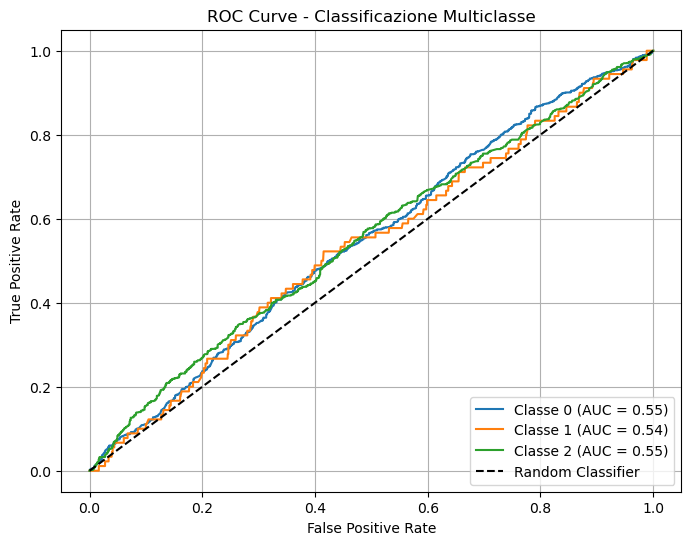

ROC AUC macro: 0.5447785266580818


In [88]:
# Otteniamo le probabilità
y_test_pred_proba = clf_c.predict_proba(X_test_enc)

# Binarizziamo le etichette (necessario per ROC multiclasse)
n_classes = y_test_pred_proba.shape[1]
y_test_binarized = label_binarize(y_test_enc, classes=np.arange(n_classes))

# Calcolo curve ROC per ogni classe
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_test_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curve
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Classe {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Classificazione Multiclasse")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# AUC complessiva
print("ROC AUC macro:", roc_auc_score(y_test_binarized, y_test_pred_proba, average="macro", multi_class="ovr"))